# Predicting variables

In [1]:
import math
import pandas as pandas
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn import preprocessing
from statistics import mean
from numpy.random import shuffle

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data_248_original = pandas.read_json("../data/device_id_248.json")
data_249_original = pandas.read_json("../data/device_id_249.json")
data_248 = data_248_original.copy()
data_249 = data_249_original.copy()
# this data will be normalized
data_248_original

,tot1,tot2,analog2
2018-12-11 12:10:00,116.15,0.00,0.82
2018-12-11 12:11:00,118.02,0.00,0.82
2018-12-11 12:12:00,119.90,0.00,0.82
2018-12-11 12:13:00,121.77,0.00,0.81
2018-12-11 12:14:00,123.64,0.00,0.82
...,...,...,...
2020-04-01 14:05:00,977428.25,-4713.21,1.54
2020-04-01 14:06:00,977428.88,-4713.21,1.54
2020-04-01 14:07:00,977429.50,-4713.21,1.54
2020-04-01 14:08:00,977430.12,-4713.21,1.54


# Normalizing the data

In [2]:
data_248 = ((data_248 - data_248.min()) / (data_248.max() - data_248.min()))
data_249 = ((data_249 - data_249.min()) / (data_249.max() - data_249.min()))

data_249

,tot1,tot2,analog2
2018-11-23 08:55:00,0.000000e+00,0.996644,0.984848
2018-11-23 08:56:00,5.770197e-07,0.996644,0.984848
2018-11-23 08:57:00,1.191671e-06,0.996644,0.984848
2018-11-23 08:58:00,1.843954e-06,0.996644,0.984848
2018-11-23 08:59:00,2.533869e-06,0.996644,0.984848
...,...,...,...
2020-04-01 08:35:00,9.999853e-01,0.000000,0.545455
2020-04-01 08:36:00,9.999903e-01,0.000000,0.530303
2020-04-01 08:37:00,9.999935e-01,0.000000,0.530303
2020-04-01 08:38:00,9.999967e-01,0.000000,0.530303


## Determining variable correlation
Here I will try to find if variables effect each other.

In [3]:
# 248
pearson_coef_tot1_248, p_value_tot1_248 = pearsonr(data_248["tot1"], data_248["analog2"]) 
pearson_coef_tot2_248, p_value_tot2_248 = pearsonr(data_248["tot2"], data_248["analog2"])

print("For device id 248")
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot1_248)) 
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot2_248))

For device id 248
Pearson Correlation Coefficient: 0.81
Pearson Correlation Coefficient: -0.28


In [4]:
# 249
pearson_coef_tot1_249, p_value_tot1_249 = pearsonr(data_249["tot1"], data_249["analog2"]) 
pearson_coef_tot2_249, p_value_tot2_249 = pearsonr(data_249["tot2"], data_249["analog2"])

print("For device id 249")
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot1_249)) 
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot2_249))


For device id 249
Pearson Correlation Coefficient: 0.14
Pearson Correlation Coefficient: -0.09


For device with id 249 we can draw a conclusion that variables "tot1" and "tot2" are not correlated(not strong enough) that we could take them into a count when building a regression model.   
But for device with id 248 there seems to be a strong correlation(0.81 coefficient) with "tot1" variable. So if we were to make a conclusion that "tot1" directly impacts "analog2" we would need data for atleast one more sensor.  
  
### Correlation between "tot1" and "tot2":

In [5]:
pearson_coef_tot_248, p_1 = pearsonr(data_248["tot1"], data_248["tot2"]) 
pearson_coef_tot_249, p_2 = pearsonr(data_249["tot1"], data_249["tot2"])

print("Pearson tot1-tot2 device 248: {:.2f}".format(pearson_coef_tot_248)) 
print("Pearson tot1-tot2 device 249: {:.2f}".format(pearson_coef_tot_249))

Pearson tot1-tot2 device 248: -0.60
Pearson tot1-tot2 device 249: -0.84


Pearson coefficient results seem to suggest that there is a strong negative correlation between "tot1" and "tot2".

## Plotting tot1 and tot2 to see the correlation 

In [6]:
MEASURED_MIN_DATE = data_248.index[0]
MEASURED_MAX_DATE = data_248.index[-1]

date_range_seconds = pandas.date_range(start=(MEASURED_MIN_DATE - pandas.Timedelta(30, unit='D')), 
                                       end=(MEASURED_MAX_DATE + pandas.Timedelta(30, unit='D')), freq="M")
date_range = []

for date in date_range_seconds:
    without_second = date.strftime('%Y-%m-%d %H:%M')
    date_range.append(without_second)
    
date_range

['2018-11-30 12:10',
 '2018-12-31 12:10',
 '2019-01-31 12:10',
 '2019-02-28 12:10',
 '2019-03-31 12:10',
 '2019-04-30 12:10',
 '2019-05-31 12:10',
 '2019-06-30 12:10',
 '2019-07-31 12:10',
 '2019-08-31 12:10',
 '2019-09-30 12:10',
 '2019-10-31 12:10',
 '2019-11-30 12:10',
 '2019-12-31 12:10',
 '2020-01-31 12:10',
 '2020-02-29 12:10',
 '2020-03-31 12:10',
 '2020-04-30 12:10']

In [7]:
y_axis_tot1_248 = data_248[["tot1"]].to_numpy()
y_axis_tot2_248 = data_248[["tot2"]].to_numpy()
timestamp_data_248 = data_248.index.tolist()
timestamp_data_248 = [str(i) for i in timestamp_data_248]

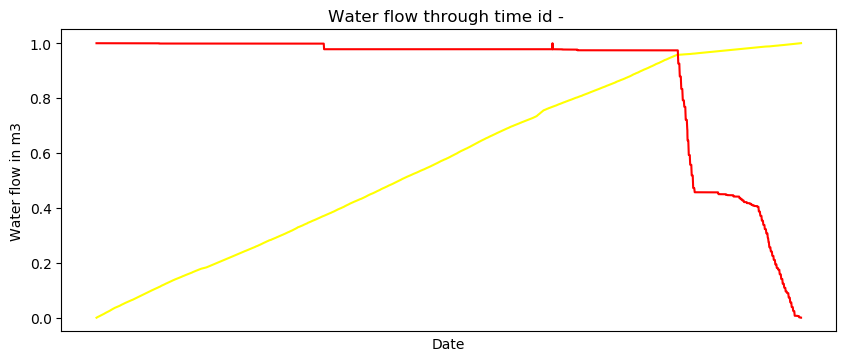

In [8]:
fig = plt.figure(figsize=(10, 4), dpi= 100, facecolor='w')
plt.plot(y_axis_tot1_248, color = "yellow")
plt.plot(y_axis_tot2_248, color = "red")

plt.xticks([], rotation=40)

plt.ylabel('Water flow in m3')
plt.xlabel('Date')
plt.title('Water flow through time id - ')
plt.show()

## Linear regresion on data for device id 249
Here I will try to find the function to fit the data and detect anomalies

In [9]:
# Already prepared data from Intial data analysis - removed empty rows and wrong dates
data_248

,tot1,tot2,analog2
2018-12-11 12:10:00,0.000000,0.999796,0.164474
2018-12-11 12:11:00,0.000002,0.999796,0.164474
2018-12-11 12:12:00,0.000004,0.999796,0.164474
2018-12-11 12:13:00,0.000006,0.999796,0.157895
2018-12-11 12:14:00,0.000008,0.999796,0.164474
...,...,...,...
2020-04-01 14:05:00,0.999997,0.000000,0.638158
2020-04-01 14:06:00,0.999998,0.000000,0.638158
2020-04-01 14:07:00,0.999999,0.000000,0.638158
2020-04-01 14:08:00,0.999999,0.000000,0.638158


Function generate data for a given timeframe

In [19]:
def draw_given_and_predicted(given, predicted):
    # takes in two arrays - 1. the actual data 2. predicted data
    fig = plt.figure(figsize=(12, 6), dpi= 100, facecolor='w')
    plt.plot([i for i in range(len(given))], given, color="blue", label="Actual values")
    plt.plot([i for i in range(len(predicted))], predicted, color="red", label="Predicted values")
    plt.legend(loc="upper left")
    plt.margins(0, 0.1)
    plt.xticks([])

    plt.ylabel('Pressure in bar')
    plt.xlabel('Cases')
    plt.title('Pressure through time')
    plt.show()

In [20]:
def generate_day_view_linear(start_date, end_date, data):
    print(start_date, end_date)
    start_day = start_date.strip() + " 00:00"
    end_day = end_date.strip() + " 23:59"
    data = data.loc[(data.index >= start_day) & (data.index <= end_day)]
    
    if len(data.index) < 1:
        raise Exception("No data for this date")
    
    # all values without pressure -> [:,:3], just pressure -> [:,3:]
    # TODO -> convert date to number format and try to find correlation ?
    data.index = pandas.to_datetime(data.index)
    matrix_X = data.reset_index().values

    # shuffle(matrix_X) # so that the sets are randomly selected
    size_of_learn_set = round(len(matrix_X) * 0.70)
    
    # Dividing data on the test and learn set
    learn_set = matrix_X[:size_of_learn_set]
    test_set  = matrix_X[size_of_learn_set:]
    
    model = LinearRegression()
    model.fit(learn_set[:,1:3], learn_set[:,3:])
    predicted_values = model.predict(test_set[:,1:3])
    
    accuracy = mean_squared_error(test_set[:,3:], predicted_values)
    draw_given_and_predicted(test_set[:,3:], predicted_values)
    
    return accuracy, matrix_X

2018-12-01 2020-04-01


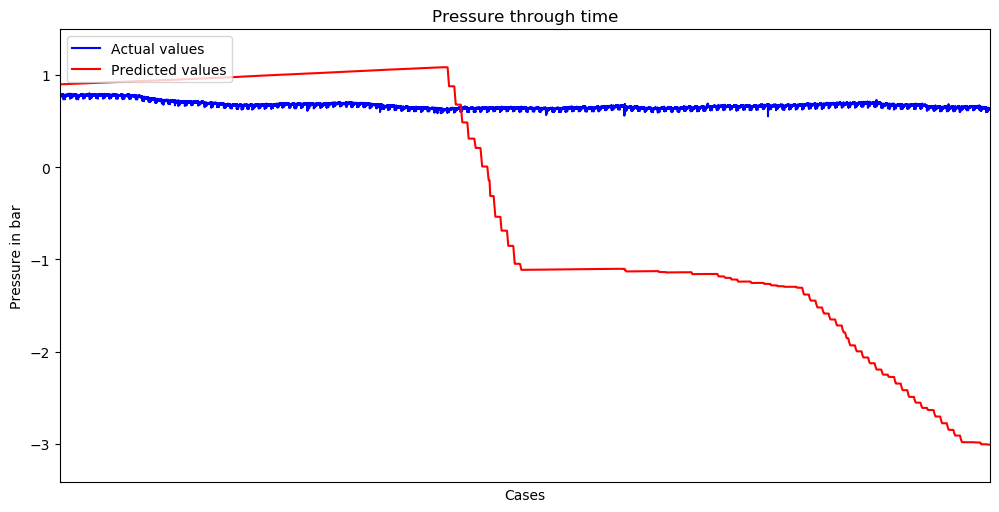

Values predicted on this time interval have an error of 2.9206065570546147 .


In [21]:
# generate_day_view("2018-01-01", "2020-04-01", data_249)
# acc = generate_day_view(str(data_249.index[0]), str(data_249.index[-1]), data_249)
acc, matrix_X_main = generate_day_view_linear("2018-12-01", "2020-04-01", data_248)
print("Values predicted on this time interval have an error of", acc, ".")

In [22]:
"""
Napovedat hocmo pritisk torej je pritisk to, napovedat ga hocmo na podlagi parametru [time, tot1, tot2]
- torej rabim za vsak pritisk matriko X [[time, tot1, tot2], [time, tot1, tot2], [time, tot1, tot2], ......]
- Y bodo pa pritiski [1.5, 1.5, 1.6, ....]
- za predictat pa vzamem spet matriko X -  [[time, tot1, tot2],... ] za en dan... -> vrne mi vrednosti
- to pol comparam z dejanskim pritiskom od takrat in zracunam razliko med napovedanim
""";

## Lasso, ridge 
Since "tot1" seems to be correlated with "analog2" for device 248 and the results of linear regression are not good i will try to use different regression models to get a good fit.

In [23]:
def generate_day_view_lasso(start_date, end_date, data):
    print(start_date, end_date)
    start_day = start_date.strip() + " 00:00"
    end_day = end_date.strip() + " 23:59"
    data = data.loc[(data.index >= start_day) & (data.index <= end_day)]
    
    if len(data.index) < 1:
        raise Exception("No data for this date")
    
    # all values without pressure -> [:,:3], just pressure -> [:,3:]
    # TODO -> convert date to number format and try to find correlation ?
    data.index = pandas.to_datetime(data.index)
    matrix_X = data.reset_index().values

    size_of_learn_set = round(len(matrix_X) * 0.70)
    
    # Dividing data on the test and learn set
    learn_set = matrix_X[:size_of_learn_set]
    test_set  = matrix_X[size_of_learn_set:]
    
    model = Ridge()
    model.fit(learn_set[:,1:3], learn_set[:,3:])
    predicted_values = model.predict(test_set[:,1:3])
    
    accuracy = mean_squared_error(test_set[:,3:], predicted_values)
    draw_given_and_predicted(test_set[:,3:], predicted_values)
    
    return accuracy, matrix_X

2018-11-01 2020-04-01


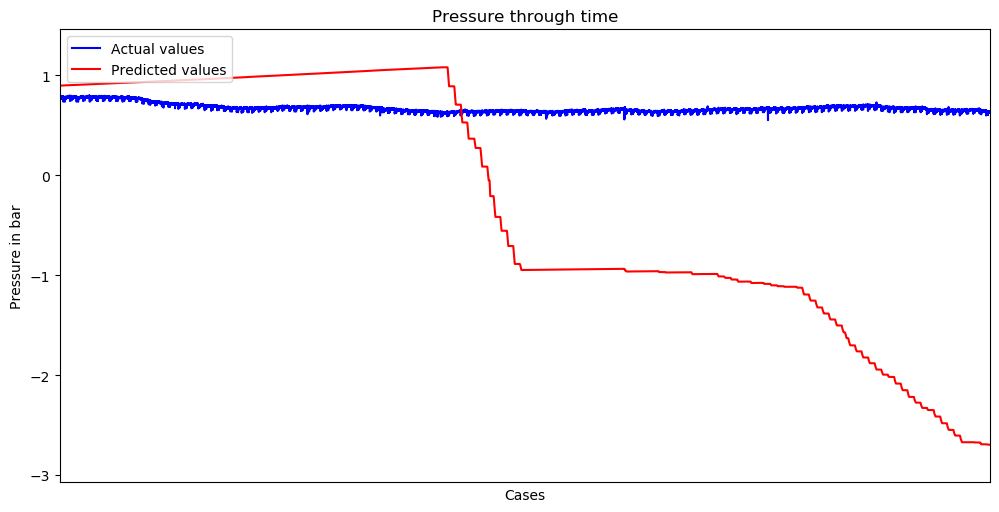

Values predicted on this time interval have an error of 2.4260676839770356 .


In [24]:
acc, matrix_X_main = generate_day_view_lasso("2018-11-01", "2020-04-01", data_248)
print("Values predicted on this time interval have an error of", acc, ".")

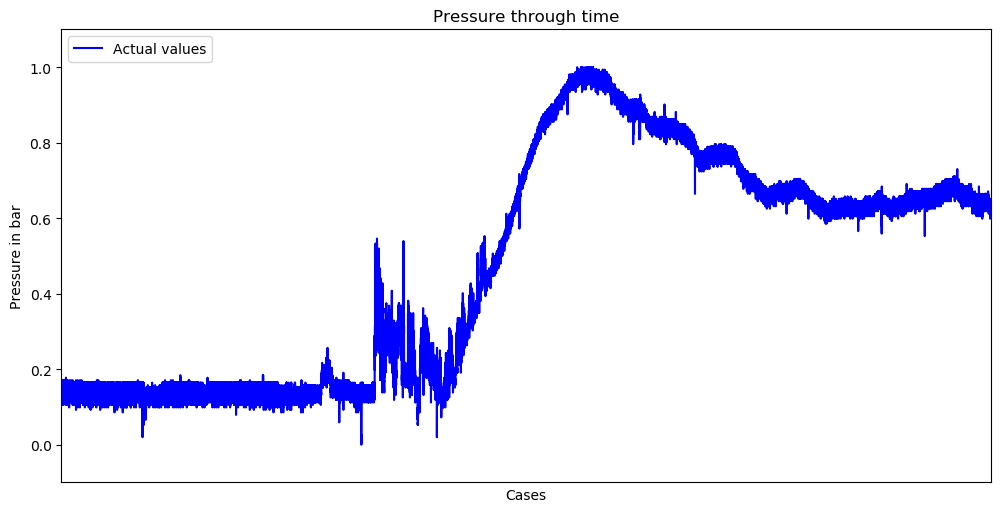

In [25]:
# takes in two arrays - 1. the actual data 2. predicted data
fig = plt.figure(figsize=(12, 6), dpi= 100, facecolor='w')
plt.plot(data_248["analog2"].to_numpy().tolist(), color="blue", label="Actual values")
plt.legend(loc="upper left")
plt.margins(0, 0.1)
plt.xticks([])

plt.ylabel('Pressure in bar')
plt.xlabel('Cases')
plt.title('Pressure through time')
plt.show()

## Libraries used for time series analysis check it

In [17]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
# dtwvis.plot_warping(s1, s2, path, filename="warp.png")

In [18]:
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [26]:
# make a good linear and polinomial regression model